<a href="https://colab.research.google.com/github/socialx-analytics/bi-02-okt-25/blob/main/003_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
import subprocess
import sys

packages = ["transformers", "pandas", "matplotlib"]

for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Import all required libraries

import pandas as pd
import re
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [3]:
# Load tweet dataset

# Read the CSV file from GitHub
url = "https://raw.githubusercontent.com/apriandito/bi-20-june/refs/heads/main/tweet_digitalcurrency_text.csv"
df = pd.read_csv(url).head(1000)

# Display the first 5 rows
df.head(5)

,created_at,screen_name,text,favorite_count,retweet_count
0,2020-12-30T19:53:02Z,PapaPapag1954,@LewisECFC @Kes1977 @herotroyippygod @GlobeSen...,0,0
1,2020-12-30T21:19:36Z,HsarafattoHogan,"@davidmcw Come on David, tell me billionaires ...",6,0
2,2020-12-30T17:57:18Z,hunter_1st,@PeterSchiff Chinas digital currency could bri...,2,0
3,2020-03-26T12:53:46Z,hunter_1st,@Bipoker @woofBIGDAWG @PeterSchiff Bitcoin is ...,1,0
4,2020-12-30T16:57:39Z,Deanmufc77,@ecb @finanzfluss And people still call the NW...,0,0


In [4]:
# Load BERT model for sentiment analysis

# Download Pretrained Model for sentiment (using Twitter-RoBERTa as alternative)
# For Indonesian, you can replace with: "mdhugol/indonesia-bert-sentiment-classification"
pretrained = "cardiffnlp/twitter-roberta-base-sentiment"

In [5]:
# Set Model and Tokenizer
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

# Set Pipeline
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [6]:
# Create functions for text cleaning and sentiment analysis

# Function to clean text for sentiment analysis
def clean_text_for_sentiment(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text[:512]  # Limit to 512 characters for BERT

# Function to perform sentiment analysis
def get_sentiment(text):
    try:
        if pd.isna(text) or text.strip() == '':
            return 'neutral', 0.0

        cleaned_text = clean_text_for_sentiment(str(text))
        result = sentiment_analysis(cleaned_text)[0]

        # Map labels to consistent format
        label_map = {
            'LABEL_0': 'negative',
            'LABEL_1': 'neutral',
            'LABEL_2': 'positive',
            'NEGATIVE': 'negative',
            'NEUTRAL': 'neutral',
            'POSITIVE': 'positive'
        }

        sentiment = label_map.get(result['label'], result['label'].lower())
        score = result['score']

        return sentiment, score
    except:
        return 'neutral', 0.0

In [7]:
# Run sentiment analysis on all tweets

# Apply sentiment analysis to all tweets
sentiments = []
scores = []

for idx, text in enumerate(df['text']):
    if idx % 100 == 0:
        print(f"Processing tweet {idx}/{len(df)}...")

    sentiment, score = get_sentiment(text)
    sentiments.append(sentiment)
    scores.append(score)

# Add sentiment results to dataframe
df['sentiment'] = sentiments
df['sentiment_score'] = scores

# Display sample results
df[['text', 'sentiment', 'sentiment_score']].head(10)

Processing tweet 0/1000...
Processing tweet 100/1000...
Processing tweet 200/1000...
Processing tweet 300/1000...
Processing tweet 400/1000...
Processing tweet 500/1000...
Processing tweet 600/1000...
Processing tweet 700/1000...
Processing tweet 800/1000...
Processing tweet 900/1000...


,text,sentiment,sentiment_score
0,@LewisECFC @Kes1977 @herotroyippygod @GlobeSen...,positive,0.625024
1,"@davidmcw Come on David, tell me billionaires ...",negative,0.506645
2,@PeterSchiff Chinas digital currency could bri...,neutral,0.576887
3,@Bipoker @woofBIGDAWG @PeterSchiff Bitcoin is ...,negative,0.718924
4,@ecb @finanzfluss And people still call the NW...,negative,0.538148
5,"to get 'clarity' finally. Naturally, a company...",neutral,0.598068
6,The Securitie &amp; Exchange Commission's accu...,neutral,0.501012
7,"@LegendaryEnergy No but, not 4 reasons most th...",negative,0.719492
8,@SkyScout2829 @LegendaryEnergy That’s part of ...,neutral,0.773333
9,Her hastanede Laboratuvar var ancak alım sadec...,neutral,0.752451


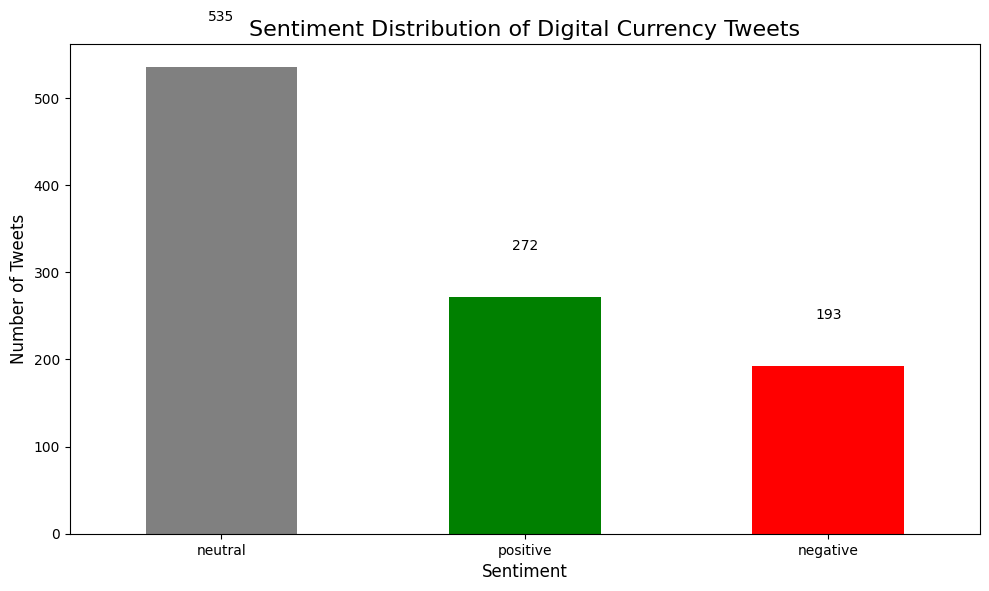

neutral: 535 tweets (53.5%)
positive: 272 tweets (27.2%)
negative: 193 tweets (19.3%)


In [8]:
# Visualize sentiment distribution

# Sentiment counts
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

# Create bar chart visualization
plt.figure(figsize=(10, 6))
colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'blue') for x in sentiment_counts.index])
plt.title('Sentiment Distribution of Digital Currency Tweets', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate percentage distribution
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{sentiment}: {count} tweets ({percentage:.1f}%)")

In [9]:
# Save results to CSV file

# Save results to CSV
output_filename = "tweet_digitalcurrency_with_sentiment.csv"
df.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

Results saved to tweet_digitalcurrency_with_sentiment.csv
